In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from models.discriminator import get_discriminator
from models.generator import get_generator
from models.encoder import get_encoder
from tqdm import tqdm
from joblib import load
import os
os.environ['CUDA_VISIBLE_DEVICES']='-1'
from pathlib import Path
from os import path
from utils.wasserstein_dist import wasserstein_dist
from utils.loaddata import generate_boundary_data, generate_interior_data, get_data
import seaborn as sns
import matplotlib

The 1-D heat equation:
$$
    \begin{split}
        & - u_t + \nu \cdot u_{xx} = 0, \hspace{1em} \text{(P.D.E.)}, \hspace{1em} (x,t) \in [-1,1] \times [0,1]\\
        & u(x, t=0) = sin(\pi x), \hspace{1em} \text{(I.C.)}\\
        & u(x=-1,t) = u(x=1,t) = 0, \hspace{1em} \text{(B.C.)}
    \end{split}
$$
where the thermal diffusivity is $\nu = \frac{1}{\pi^2}$. The unique solution for the above deterministic problem (without uncertainty) is $u(x,t)=\sin(\pi x) \cdot e^{-t}$. Here, we assume that the initial condition is random, i.e., 
$$
    \begin{split}
        & u(x,t=0)= \sin (\pi x) + \delta_1, \hspace{1em} \delta_1 = \frac{\epsilon_1}{\exp(3|x|-1)}, \hspace{1em} \epsilon_1 \sim \mathcal{N}(0,\sigma_1), \hspace{1em} \text{(I.C.)}\\
        & u(x=-1,t) = u(x=1,t) = 0, \hspace{1em} \text{(B.C.)}
    \end{split}
$$
with the noise level $\sigma_1 = 0.05$.

In [2]:
tf.random.set_seed(666666)
np.random.seed(666666)

# Define some hyper-parameters 
noise_level = 0.05
par_pinns = 1 # hyperparameter to balance wgan and pinns regularization term
N_r = 500 # number of training data for residual (k in my paper)
N_u = 800 # number of training data for uncertain boundary/initial conditions (m=n in my paper)
z_shape = 2 # we adopt 2-dimensional standard normal noise as input for uncertainty quantification
g_depth = 3 # depth of generators (D_g)
g_width = 50 # width of generators (W_g)
d_depth = 3 # depth of discriminators (D_f)
d_width = 50 # width of discriminators
lrg = 1e-4 # learning rate for generators
lrd = 1e-4 # learning rate for discriminators
beta_1 = 0.9
beta_2 = 0.99 # those two beta_s are for Adam optimizor.
bjorck_beta = 0.5 
bjorck_iter = 5
bjorck_order = 2 # hyper-parameters for bjorck orthonomalization iteration
group_size = 2 # groupsize of groupsort neural networks
num_itr = 30000 # maximun number of itertions

In [3]:
class WGAN_PINNs(object):

    def __init__(self,
                 noise_level=0.05,
                 N_r=200,
                 N_u=20,
                 X_mean=0,
                 X_std=1,
                 T_mean=1,
                 T_std=1,
                 par_pinns=1,
                 z_shape=2,
                 out_dim=1,
                 num_itr=30000,
                 g_depth=3,
                 g_width=50,
                 d_depth=3,
                 d_width=50,
                 lrg=1e-4,
                 lrd=1e-4,
                 beta_1=0.9,
                 beta_2=0.999,
                 bjorck_beta=0.5,
                 bjorck_iter=5,
                 bjorck_order=2,
                 group_size=2):

        self.noise_level = noise_level
        self.N_r = N_r
        self.N_u = N_u
        self.X_mean = X_mean
        self.X_std = X_std
        self.T_mean = T_mean
        self.T_std = T_std
        self.z_shape = z_shape
        self.out_dim = out_dim
        self.num_itr = num_itr
        self.JacobianX = 1 / self.X_std
        self.JacobianT = 1 / self.T_std
        self.par_pinns = par_pinns
        self.x_shape = 2
        self.k_d = 2
        self.k_g = 5

        self.d_depth = d_depth
        self.d_width = d_width
        self.g_depth = g_depth
        self.g_width = g_width

        # network initialization
        self.G = get_generator(input_shape=(self.z_shape + self.x_shape,), output_shape=self.out_dim, depth=g_depth,
                               width=g_width)
        self.D = get_discriminator(input_shape=(self.out_dim + self.x_shape,), depth=d_depth, width=d_width,
                                   bjorck_beta=bjorck_beta, bjorck_iter=bjorck_iter, bjorck_order=bjorck_order,
                                   group_size=group_size)
        self.G_optimizer = Adam(learning_rate=lrg, beta_1=beta_1, beta_2=beta_2)
        self.D_optimizer = Adam(learning_rate=lrd, beta_1=beta_1, beta_2=beta_2)

        self.Loss = 0.0
    
    # r.h.s. of the pde
    def f(self, X_normalized):
        return 0.0

    def generator_loss(self, fake_output, residual):
        return tf.math.reduce_mean(fake_output) + self.par_pinns * residual

    def discriminator_loss(self, real_output, fake_output):
        return -tf.math.reduce_mean(fake_output) + tf.math.reduce_mean(real_output)
    
    # get residual
    def get_r(self, XT_r, noises):
        X_r = XT_r[:, 0][:, None]
        T_r = XT_r[:, 1][:, None]
        with tf.GradientTape(watch_accessed_variables=False) as pde_tape2:
            pde_tape2.watch(X_r)
            with tf.GradientTape(persistent=True, watch_accessed_variables=False) as pde_tape1:
                pde_tape1.watch([X_r, T_r])
                u = self.G(tf.concat([noises, X_r, T_r], axis=1), training=True)
            u_x = pde_tape1.gradient(u, X_r)
            u_t = pde_tape1.gradient(u, T_r)
            # print(tf.shape(u_x))
        u_xx = pde_tape2.gradient(u_x, X_r)
        # tf.print(tf.shape(u_xx))
        f = self.f(X_r)
        r = -u_t * self.JacobianT + u_xx / (np.pi ** 2) * (self.JacobianX ** 2) - f
        r2 = r ** 2
        return tf.math.reduce_mean(r2)

    @tf.function()
    def train_step_discriminator(self, X_u, XY_u, noises_u):
        with tf.GradientTape() as disc_tape:
            generated_Y = self.G(tf.concat([noises_u, X_u], axis=1), training=False)

            real_output = self.D(XY_u, training=True)
            fake_output = self.D(tf.concat([X_u, generated_Y], axis=1), training=True)

            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.D.trainable_variables)

        self.D_optimizer.apply_gradients(zip(gradients_of_discriminator, self.D.trainable_variables))

    @tf.function()
    def train_step_generator(self, X_u, X_r, noises_u, noises_r):
        with tf.GradientTape() as gen_tape:
            generated_Y = self.G(tf.concat([noises_u, X_u], axis=1), training=True)

            fake_output = self.D(tf.concat([X_u, generated_Y], axis=1), training=False)

            residual = self.get_r(X_r, noises_r)

            gen_loss = self.generator_loss(fake_output, residual)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.G.trainable_variables)

        self.G_optimizer.apply_gradients(zip(gradients_of_generator, self.G.trainable_variables))
    
    # generator one sample at X
    def generate_sample(self, X):
        num = X.shape[0]
        noise = tf.random.normal([num, self.z_shape])
        return self.G(tf.concat([noise, X], axis=1), training=False)

    # calculate relative error of the generator
    def get_relative_error(self, X, Y, l2, num_test):
        samples = np.zeros((num_test, 2000), dtype=np.float32)
        for i in range(0, 2000):
            samples[:, i:i + 1] = self.generate_sample(X)

        Y_predicted = np.mean(samples, axis=1, dtype=np.float32)[:, None]

        return np.sqrt(tf.reduce_mean(tf.square(Y_predicted - Y)) / l2)
    
    # minibacth
    def get_minibatch(self, XY_r, XYU_u, XY_u, batchsize_r=100, batchsize_u = 50):
        idx_r = np.random.choice(self.N_r, batchsize_r, replace=False)
        idx_u = np.random.choice(self.N_u * 2, batchsize_u, replace=False)

        return XY_r[idx_r,:], XYU_u[idx_u,:], XY_u[idx_u,:]

    def train(self, XTY_u, XT_r, XT_test):
        print('--------------Begin Training-----------------')
        num = 1000
        XTY = generate_boundary_data(noise_level=self.noise_level, N_u=num, X_mean=self.X_mean, X_std=self.X_std,
                                     T_mean=self.T_mean, T_std=self.T_std)
        XT = XTY[:, 0:2]
        
        num_test = XT_test.shape[0]
        XT_u = XTY_u[:, 0:2]
        XT_test = tf.convert_to_tensor(XT_test)
        
        time1 = time.time()
        batchsize_r = 500
        batchsize_u = 1000
        for itr in range(self.num_itr):

            XT_r_batch, XTY_u_batch, XT_u_batch = self.get_minibatch(XT_r, XTY_u, XT_u, batchsize_r, batchsize_u)
            noises_u = tf.random.normal([batchsize_u, self.z_shape])
            noises_r = tf.random.normal([batchsize_r, self.z_shape])
            for i in range(self.k_d):
                self.train_step_discriminator(XT_u_batch, XTY_u_batch, noises_u)

            for j in range(self.k_g):
                self.train_step_generator(XT_u_batch, XT_r_batch, noises_u, noises_r)

            if (itr + 1) % 5000 == 0:
                noises_u = tf.random.normal([2 * num, self.z_shape])
                noises_test = tf.random.normal([num_test, self.z_shape])
                r2_loss = self.get_r(XT_test, noises_test)
                u_predict = self.G(tf.concat([noises_u, XT], axis=1), training=False)
                w_dis = tf.math.reduce_mean(
                    self.D(tf.concat([XT, u_predict], axis=1), training=False)) - tf.math.reduce_mean(
                    self.D(XTY, training=False))
                print(
                    "itr {}, r2_loss is {:4f}, W loss is {:5f}; Time: {:4f}.\n".format(
                        itr + 1, r2_loss, w_dis,
                        time.time() - time1))
                time1 = time.time()

In [4]:
XTY_u, XT_r, XT_test, X_mean, X_std, T_mean, T_std = get_data(noise_level=noise_level, N_r = N_r, N_u = N_u)

wgan_pinns = WGAN_PINNs(noise_level=noise_level, N_r=N_r, N_u=N_u, X_mean=X_mean, X_std=X_std, T_mean=T_mean, T_std=T_std, par_pinns=par_pinns, z_shape=z_shape, num_itr=num_itr, 
                        g_depth=g_depth, g_width=g_width, d_depth=d_depth, d_width=d_width, lrg=lrg, lrd=lrd, beta_1=beta_1, beta_2=beta_2, bjorck_beta=bjorck_beta, 
                        bjorck_iter=bjorck_iter, bjorck_order=bjorck_order, group_size=group_size)

wgan_pinns.train(XTY_u, XT_r, XT_test)

--------------Begin Training-----------------
itr 5000, r2_loss is 0.000027, W loss is -0.000176; Time: 141.593734.

itr 10000, r2_loss is 0.000022, W loss is -0.000307; Time: 138.846694.

itr 15000, r2_loss is 0.000025, W loss is -0.000081; Time: 138.856476.

itr 20000, r2_loss is 0.000037, W loss is 0.000193; Time: 139.878348.

itr 25000, r2_loss is 0.000045, W loss is -0.000181; Time: 140.381003.

itr 30000, r2_loss is 0.000030, W loss is -0.000226; Time: 140.456150.



In [5]:
def get_solution(XT_normalized, X_mean, X_std, T_mean, T_std):
    X = XT_normalized[:, 0][:, None] * X_std + X_mean
    T = XT_normalized[:, 1][:, None] * T_std + T_mean
    return np.sin(np.pi * X) * np.exp(-T)

XT_test = generate_interior_data(N_test=100, X_mean=X_mean, X_std=X_std, T_mean=T_mean, T_std=T_std)
Y_test = get_solution(XT_test, X_mean=X_mean, X_std=X_std, T_mean=T_mean, T_std=T_std)
l2 = np.mean(np.square(Y_test))
samples = np.zeros((100*100, 2000), dtype=np.float32)
for i in range(0, 2000):
    samples[:, i:i + 1] = wgan_pinns.generate_sample(XT_test)
Y_predicted = np.mean(samples, axis=1)[:,None]
rel_error = np.sqrt(np.mean(np.square(Y_predicted - Y_test)) / l2)
print('The relative error of ontained generator is {:.3e}.'.format(rel_error))

The relative error of ontained generator is 1.246e-02.


draw the initial conditions

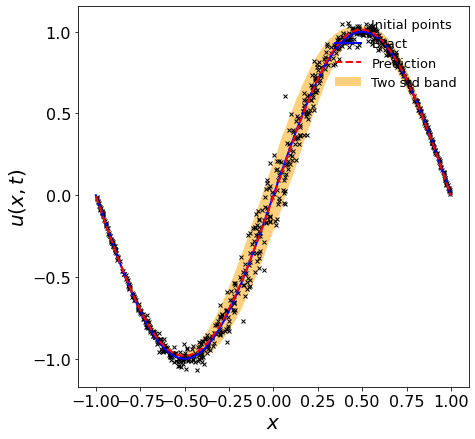

In [6]:
X_test = (np.linspace(-1, 1, 201) - X_mean) / X_std
T_test = (np.linspace(0, 1, 5) - T_mean) / T_std
X_test = np.broadcast_to(X_test[None, :, None], (5, 201, 1))
T_test = np.broadcast_to(T_test[:, None, None], (5, 201, 1))
XT_test = np.concatenate((X_test, T_test), axis=-1)
XT_test = np.reshape(XT_test, newshape=(-1, 2))

samples = np.zeros((5*201, 2000), dtype=np.float32)
for i in range(0, 2000):
    samples[:, i:i + 1] = wgan_pinns.generate_sample(XT_test)

data = samples[201*0:201*1,:]

XTY_u1 = XTY_u[0:N_u,:]
X_u1 = XTY_u1[:,0][:,None] * X_std + X_mean
Y_u1 = XTY_u1[:,2][:,None]

X_ref = np.linspace(-1.,1.,201)[:,None]
Y_ref = np.sin(np.pi * X_ref)*np.exp(-0.25*0)

# Plot the prediction with the uncertainty versus the reference solution
mu_pred = np.mean(data, axis = 1)    
Sigma_pred = np.var(data, axis = 1)
# Sigma_pred = 0.05**2

ax = plt.figure(figsize=(7,7))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
lower = mu_pred - 2.0*np.sqrt(Sigma_pred)
upper = mu_pred + 2.0*np.sqrt(Sigma_pred)
plt.plot(X_u1, Y_u1, 'kx', markersize = 4, label = "Initial points")
plt.fill_between(X_ref.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
plt.plot(X_ref,Y_ref,'b-', label = "Exact", linewidth=2)
plt.plot(X_ref, mu_pred, 'r--', label = "Prediction", linewidth=2)
plt.xlabel('$x$',fontsize=20)
plt.ylabel('$u(x,t)$',fontsize=20)
# plt.axis('square')
# plt.xlim([-1.1,1.1])
# plt.ylim([-1.1,1.1])
plt.legend(loc='upper right', frameon=False, prop={'size': 13})
plt.show()

The above is the tutorial part. The following part shows the relative error during the training. The relative error decreases fast at the first 30 thousand iterations, and then becomes stable within the range from 7e-3 to 5e-2.

In [7]:
! python run.py train --hparam='basic_params1'

--------------Begin Training-----------------
epoch_2000, rel_error is 3.384935e-02 r2_loss is 0.000078, W loss is -0.000108; Time: 72.531244.

epoch_4000, rel_error is 1.019762e-01 r2_loss is 0.000019, W loss is -0.000125; Time: 68.765519.

epoch_6000, rel_error is 2.094970e-01 r2_loss is 0.000100, W loss is -0.000462; Time: 69.281346.

epoch_8000, rel_error is 1.757958e-01 r2_loss is 0.000054, W loss is -0.000185; Time: 69.642035.

epoch_10000, rel_error is 6.368414e-02 r2_loss is 0.000047, W loss is -0.000041; Time: 70.217272.

epoch_12000, rel_error is 7.146884e-02 r2_loss is 0.000048, W loss is 0.000153; Time: 69.843786.

epoch_14000, rel_error is 3.325370e-02 r2_loss is 0.000036, W loss is -0.000063; Time: 70.437476.

epoch_16000, rel_error is 1.256155e-01 r2_loss is 0.000051, W loss is -0.000490; Time: 70.578200.

epoch_18000, rel_error is 1.213612e-01 r2_loss is 0.000041, W loss is -0.000216; Time: 71.421799.

epoch_20000, rel_error is 1.237572e-01 r2_loss is 0.000031, W loss i

2021-07-28 23:43:13.137024: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library cudart64_101.dll
2021-07-28 23:43:15.563153: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library nvcuda.dll
2021-07-28 23:43:15.590440: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-07-28 23:43:15.592872: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: GAOYihang
2021-07-28 23:43:15.592928: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: GAOYihang
2021-07-28 23:43:15.593326: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow w

epoch_46000, rel_error is 6.459418e-02 r2_loss is 0.000039, W loss is -0.000016; Time: 90.217398.

epoch_48000, rel_error is 2.068004e-02 r2_loss is 0.000040, W loss is -0.000105; Time: 91.937507.

epoch_50000, rel_error is 1.960277e-02 r2_loss is 0.000038, W loss is -0.000151; Time: 95.031247.

epoch_52000, rel_error is 4.474802e-02 r2_loss is 0.000037, W loss is -0.000199; Time: 119.312611.

epoch_54000, rel_error is 3.346527e-02 r2_loss is 0.000063, W loss is -0.000157; Time: 124.484228.

epoch_56000, rel_error is 5.145009e-02 r2_loss is 0.000086, W loss is -0.000153; Time: 126.515659.

epoch_58000, rel_error is 2.390640e-02 r2_loss is 0.000078, W loss is -0.000132; Time: 129.749948.

epoch_60000, rel_error is 4.901809e-02 r2_loss is 0.000070, W loss is -0.000044; Time: 133.640728.

epoch_62000, rel_error is 1.349528e-02 r2_loss is 0.000080, W loss is -0.000076; Time: 138.109348.

epoch_64000, rel_error is 3.137360e-02 r2_loss is 0.000074, W loss is -0.000210; Time: 142.626343.

epo

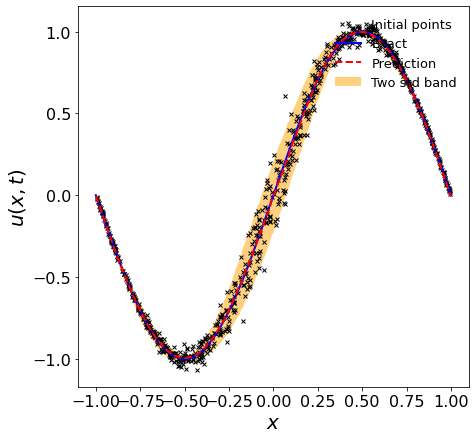

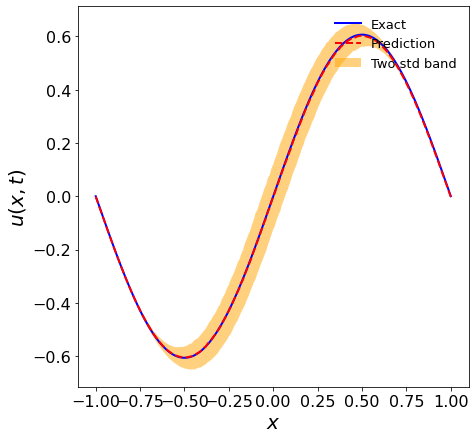

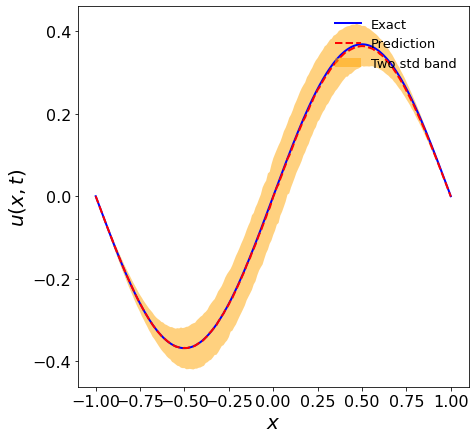

In [8]:
samples = np.load('data_0.05.npy')



data = samples[201*0:201*1,:]

XTY_u1 = XTY_u[0:N_u,:]
X_u1 = XTY_u1[:,0][:,None] * X_std + X_mean
Y_u1 = XTY_u1[:,2][:,None]

X_ref = np.linspace(-1.,1.,201)[:,None]
Y_ref = np.sin(np.pi * X_ref)*np.exp(-0.25*0)

# Plot the prediction with the uncertainty versus the reference solution
mu_pred = np.mean(data, axis = 1)    
Sigma_pred = np.var(data, axis = 1)
ax = plt.figure(figsize=(7,7))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
lower = mu_pred - 2.0*np.sqrt(Sigma_pred)
upper = mu_pred + 2.0*np.sqrt(Sigma_pred)
plt.plot(X_u1, Y_u1, 'kx', markersize = 4, label = "Initial points")
plt.fill_between(X_ref.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
plt.plot(X_ref,Y_ref,'b-', label = "Exact", linewidth=2)
plt.plot(X_ref, mu_pred, 'r--', label = "Prediction", linewidth=2)
plt.xlabel('$x$',fontsize=20)
plt.ylabel('$u(x,t)$',fontsize=20)
# plt.axis('square')
# plt.xlim([-1.1,1.1])
# plt.ylim([-1.1,1.1])
plt.legend(loc='upper right', frameon=False, prop={'size': 13})
plt.show()



X_ref = np.linspace(-1.,1.,201)[:,None]
Y_ref = np.sin(np.pi * X_ref)*np.exp(-0.25*2)
data = samples[201*2:201*3,:]
mu_pred = np.mean(data, axis = 1)    
Sigma_pred = np.var(data, axis = 1)
ax = plt.figure(figsize=(7,7))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
lower = mu_pred - 2.0*np.sqrt(Sigma_pred)
upper = mu_pred + 2.0*np.sqrt(Sigma_pred)
plt.fill_between(X_ref.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
plt.plot(X_ref,Y_ref,'b-', label = "Exact", linewidth=2)
plt.plot(X_ref, mu_pred, 'r--', label = "Prediction", linewidth=2)
plt.xlabel('$x$',fontsize=20)
plt.ylabel('$u(x,t)$',fontsize=20)
# plt.axis('square')
# plt.xlim([-1.1,1.1])
# plt.ylim([-1.1,1.1])
plt.legend(loc='upper right', frameon=False, prop={'size': 13})
plt.show()



X_ref = np.linspace(-1.,1.,201)[:,None]
Y_ref = np.sin(np.pi * X_ref)*np.exp(-0.25*4)
data = samples[201*4:201*5,:]
mu_pred = np.mean(data, axis = 1)    
Sigma_pred = np.var(data, axis = 1)
ax = plt.figure(figsize=(7,7))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
lower = mu_pred - 2.0*np.sqrt(Sigma_pred)
upper = mu_pred + 2.0*np.sqrt(Sigma_pred)
plt.fill_between(X_ref.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
plt.plot(X_ref,Y_ref,'b-', label = "Exact", linewidth=2)
plt.plot(X_ref, mu_pred, 'r--', label = "Prediction", linewidth=2)
plt.xlabel('$x$',fontsize=20)
plt.ylabel('$u(x,t)$',fontsize=20)
# plt.axis('square')
# plt.xlim([-1.1,1.1])
# plt.ylim([-1.1,1.1])
plt.legend(loc='upper right', frameon=False, prop={'size': 13})
plt.show()

D:\Softwares\miniconda3\envs\gyh_tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Softwares\miniconda3\envs\gyh_tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


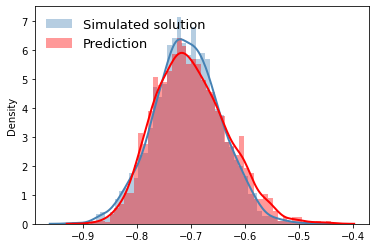

D:\Softwares\miniconda3\envs\gyh_tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Softwares\miniconda3\envs\gyh_tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


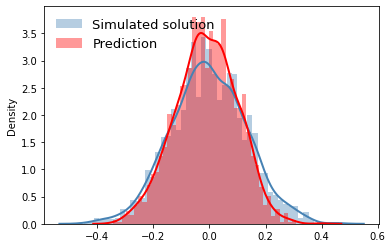

D:\Softwares\miniconda3\envs\gyh_tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Softwares\miniconda3\envs\gyh_tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


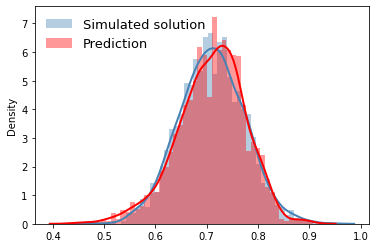

In [9]:
Y2 = np.random.normal(loc=0,scale=1/np.exp(3*0.25-1)*0.05,size=(1,2000))
Y2 = np.sin(np.pi*(-0.25))+Y2
data = samples[201*0+75,:]
Y1 = data
plt.figure()
sns.distplot(Y2, hist=True, kde=True, bins=50, color='steelblue', hist_kws={'edgecolor':'None'}, kde_kws={'linewidth':2}, label='Simulated solution')
sns.distplot(Y1, hist=True, kde=True, bins=50, color='red', hist_kws={'edgecolor':'None'}, kde_kws={'linewidth':2}, label="Prediction")
plt.legend(loc='upper left', frameon=False, prop={'size': 13})
plt.show()

Y2 = np.random.normal(loc=0,scale=1/np.exp(3*0-1)*0.05,size=(1,2000))
Y2 = np.sin(np.pi*(0))+Y2
data = samples[201*0+100,:]
Y1 = data
plt.figure()
sns.distplot(Y2, hist=True, kde=True, bins=50, color='steelblue', hist_kws={'edgecolor':'None'}, kde_kws={'linewidth':2}, label='Simulated solution')
sns.distplot(Y1, hist=True, kde=True, bins=50, color='red', hist_kws={'edgecolor':'None'}, kde_kws={'linewidth':2}, label="Prediction")
plt.legend(loc='upper left', frameon=False, prop={'size': 13})
plt.show()

Y2 = np.random.normal(loc=0,scale=1/np.exp(3*0.25-1)*0.05,size=(1,2000))
Y2 = np.sin(np.pi*(0.25))+Y2
data = samples[201*0+125,:]
Y1 = data
plt.figure()
sns.distplot(Y2, hist=True, kde=True, bins=50, color='steelblue', hist_kws={'edgecolor':'None'}, kde_kws={'linewidth':2}, label='Simulated solution')
sns.distplot(Y1, hist=True, kde=True, bins=50, color='red', hist_kws={'edgecolor':'None'}, kde_kws={'linewidth':2}, label="Prediction")
plt.legend(loc='upper left', frameon=False, prop={'size': 13})
plt.show()